In [192]:
import numpy as np
import tqdm
import statsmodels.tsa.stattools
import scipy.signal
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

In [2]:
T = 14000
n_steps_per_unit_time = 10
dt = 1/n_steps_per_unit_time
window_length = 700
n_windows = int(T/window_length) 

In [3]:
n_parameter_settings = 1000

np.random.seed(1)

l0s = np.random.uniform(0.3,0.5,n_parameter_settings)
th0s = np.random.uniform(0.5,4,n_parameter_settings)
thTs = np.random.uniform(0.5,4,n_parameter_settings)    
k0s = np.random.uniform(0.5,4,n_parameter_settings)
kTs = np.random.uniform(0.5,4,n_parameter_settings)

In [10]:
l0s = np.random.uniform(0.3,0.5,n_parameter_settings)
th0s = np.ones(n_parameter_settings)
thTs = np.ones(n_parameter_settings)
k0s = np.ones(n_parameter_settings)
kTs = np.ones(n_parameter_settings)

In [117]:
#linear ramp for kappa
def kappa(t,k0,kT):
    return (1-t/T)*k0 + t/T*kT

#linear ramp for theta
def theta(t,th0,thT):
    return (1-t/T)*th0 + t/T*thT


def ls(t,l0):
    return l0*np.sqrt(1-t/T)



def get_var(x):
    #get var of T-windows with length window length. Gives n_windows values
    var = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        var[i] = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2).var()
    return var


def get_ar(x):
#x should have size T*steps_per_unit_time + 1
    ar = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        ar[i] = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2))[1]
    return ar

#ls version without convolution

def get_ls_k(x,noise,k0,kT):


    def fitfunction(f,ls):
        return np.log(1/(f**2  + ls**2))
    
    ls = np.full(n_windows,np.nan)



    for i in tqdm.trange(n_windows):
        frequencies = 2*np.pi*(1/window_length)*np.arange(1,window_length/2)                                                #here window_length should be even

        xs_window_detrend = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2)
        noise_window = noise[i*window_length:(i+1)*window_length]
        kappa_window = kappa(np.arange(i*window_length,(i+1)*window_length),k0,kT)                                                                               
        
        estim_psd_xs_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[j]*np.arange(0,window_length)) @ xs_window_detrend))**2 for j in range(int(window_length/2) - 1)])
        estim_psd_xi_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[n]*np.arange(0,window_length)) @ (noise_window*kappa_window)))**2 for n in range(int(window_length/2) - 1)])

        popt = scipy.optimize.curve_fit(fitfunction,
                                                frequencies, 
                                                np.log(estim_psd_xs_wn/estim_psd_xi_wn),
                                                p0=[1.0],
                                                bounds=(0.0, np.inf))[0]
        ls[i] = popt[0]

    return ls


In [5]:
def get_paths_decreasing_ls(l0,k0,kT,th0,thT):
    #simulate sample paths with euler method with decreasing ls 
    n_steps = T*n_steps_per_unit_time
    solve_ts = np.linspace(0,T,n_steps + 1)


    xs = np.zeros(n_steps+1)
    us = np.zeros(n_steps+1)

    #simulate us
    for i in tqdm.trange(n_steps):
        us[i+1] = np.exp(-theta(solve_ts[i],th0,thT)*dt)*us[i] + np.sqrt(1/(2*theta(solve_ts[i],th0,thT))*(1-np.exp(-2*theta(solve_ts[i],th0,thT)*dt)))*np.random.normal(0,1)

    for i in tqdm.trange(n_steps):
        xs[i+1] = xs[i] - ls(solve_ts[i],l0)*xs[i]*dt + kappa(solve_ts[i],k0,kT)*us[i]*dt

    xs_filtered = xs[::n_steps_per_unit_time]
    us_filtered = np.array([np.sum([us[i*n_steps_per_unit_time+j] for j in range(n_steps_per_unit_time)])*dt for i in range(T)])
    return xs_filtered, us_filtered



def get_paths_fix_l0(l0,k0,kT,th0,thT):
    #simulate sample paths with euler method with fix l0 value
    n_steps = T*n_steps_per_unit_time
    solve_ts = np.linspace(0,T,n_steps + 1)


    xs = np.zeros(n_steps+1)
    us = np.zeros(n_steps+1)

    #simulate us
    for i in tqdm.trange(n_steps):
        us[i+1] = np.exp(-theta(solve_ts[i],th0,thT)*dt)*us[i] + np.sqrt(1/(2*theta(solve_ts[i],th0,thT))*(1-np.exp(-2*theta(solve_ts[i],th0,thT)*dt)))*np.random.normal(0,1)

    for i in tqdm.trange(n_steps):
        xs[i+1] = xs[i] - l0*xs[i]*dt + kappa(solve_ts[i],k0,kT)*us[i]*dt

    xs_filtered = xs[::n_steps_per_unit_time]
    us_filtered = np.array([np.sum([us[i*n_steps_per_unit_time+j] for j in range(n_steps_per_unit_time)])*dt for i in range(T)])
    return xs_filtered, us_filtered

In [6]:
reference = np.arange(n_windows)

kendall_taus = np.zeros((n_parameter_settings*2,3))

In [7]:
for i in tqdm.trange(n_parameter_settings):
    l0, th0, thT, k0, kT = l0s[i], th0s[i], thTs[i], k0s[i], kTs[i]
    
    xs_filtered_decr_ls, us_filtered = get_paths_decreasing_ls(l0, k0, kT, th0, thT)
    xs_filtered_fix_l0, us_filtered = get_paths_fix_l0(l0, k0, kT, th0, thT)

    var_xs_decr_ls = get_var(xs_filtered_decr_ls)
    ar_xs_decr_ls = get_ar(xs_filtered_decr_ls)
    ls_xs_decr_ls = get_ls_k(xs_filtered_decr_ls,us_filtered,k0,kT)

    kendall_taus[2*i,0] = kendalltau(reference,var_xs_decr_ls)[0]
    kendall_taus[2*i,1] = kendalltau(reference,ar_xs_decr_ls)[0]
    kendall_taus[2*i,2] = kendalltau(reference,-ls_xs_decr_ls)[0]

    
    var_xs_fix_l0 = get_var(xs_filtered_fix_l0)
    ar_xs_fix_l0 = get_ar(xs_filtered_fix_l0)
    ls_xs_fix_l0 = get_ls_k(xs_filtered_fix_l0,us_filtered,k0,kT)

    
    kendall_taus[2*i+1,0] = kendalltau(reference,var_xs_fix_l0)[0]
    kendall_taus[2*i+1,1] = kendalltau(reference,ar_xs_fix_l0)[0]
    kendall_taus[2*i+1,2] = kendalltau(reference,-ls_xs_fix_l0)[0]

100%|██████████| 1000/1000 [2:23:46<00:00,  8.63s/it]


In [12]:
kendall_taus_decreasing_ls_var = kendall_taus[::2,0]
kendall_taus_decreasing_ls_ar = kendall_taus[::2,1]
kendall_taus_decreasing_ls_ls = kendall_taus[::2,2]


kendall_taus_fix_l0_var = kendall_taus[1::2,0]
kendall_taus_fix_l0_ar = kendall_taus[1::2,1]
kendall_taus_fix_l0_ls = kendall_taus[1::2,2]

(array([ 78., 113.,  87., 107., 108., 103., 111., 109., 119.,  65.]),
 array([-0.87368421, -0.69578947, -0.51789474, -0.34      , -0.16210526,
         0.01578947,  0.19368421,  0.37157895,  0.54947368,  0.72736842,
         0.90526316]),
 <BarContainer object of 10 artists>)

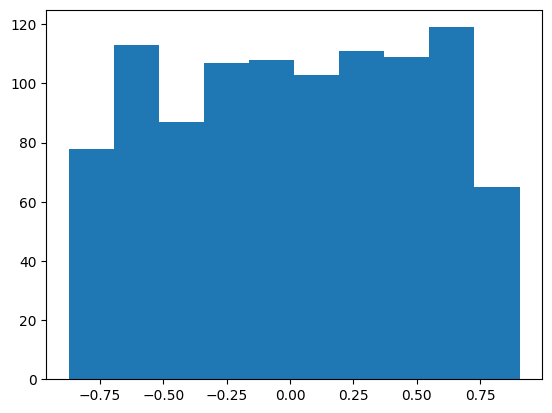

In [159]:
plt.hist(kendall_taus_fix_l0_ar)

In [188]:
#get ROC curve
n = 1001
thresholds = np.linspace(1,-1,n)

true_positives = np.zeros((n,3))
false_positives = np.zeros((n,3))


for i in tqdm.trange(n):

    true_positives[i,0] = np.mean(kendall_taus_decreasing_ls_var > thresholds[i])
    true_positives[i,1] = np.mean(kendall_taus_decreasing_ls_ar >  thresholds[i])
    true_positives[i,2] = np.mean(kendall_taus_decreasing_ls_ls >  thresholds[i])

    false_positives[i,0] = np.mean(kendall_taus_fix_l0_var >  thresholds[i])
    false_positives[i,1] = np.mean(kendall_taus_fix_l0_ar >  thresholds[i])
    false_positives[i,2] = np.mean(kendall_taus_fix_l0_ls >  thresholds[i])



100%|██████████| 1001/1001 [00:00<00:00, 13924.77it/s]


In [55]:
thresholds[500]

0.0

In [58]:
false_positives[:,2][500]

49.6

In [189]:
#compute AUC values
var_fp_x = np.concatenate((np.array([0]),false_positives[:,0][1:]-false_positives[:,0][:-1]))
ac_fp_x = np.concatenate((np.array([0]),false_positives[:,1][1:]-false_positives[:,1][:-1]))
ROSA_fp_x = np.concatenate((np.array([0]),false_positives[:,2][1:]-false_positives[:,2][:-1]))

auc_var = np.round(np.dot(var_fp_x,true_positives[:,0]),2)
auc_ac = np.round(np.dot(ac_fp_x,true_positives[:,1]),2)
auc_ls = np.round(np.dot(ROSA_fp_x,true_positives[:,2]),2)

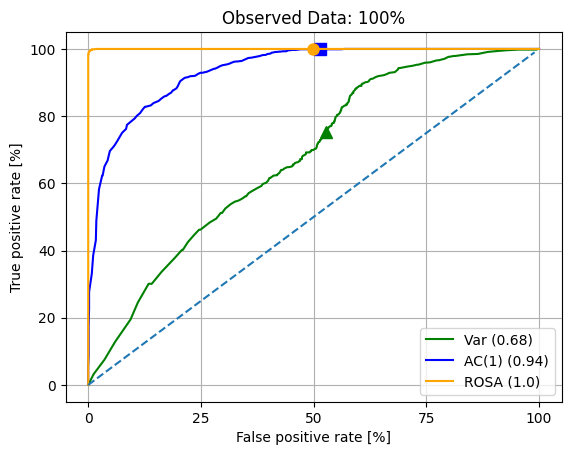

In [190]:
false_positives = false_positives*100
true_positives = true_positives*100


fig, ax = plt.subplots()

ax.plot(false_positives[:,0],true_positives[:,0], color = "green", label = f"Var ({auc_var})")
ax.plot(false_positives[:,0][500],true_positives[:,0][500],marker = '^',markersize = 8,color='green')
ax.plot(false_positives[:,1],true_positives[:,1], color = "blue", label = f"AC(1) ({auc_ac})")
ax.plot(false_positives[:,1][500],true_positives[:,1][500],marker = 's',markersize = 8,color='blue')
ax.plot(false_positives[:,2],true_positives[:,2], color = "orange", label = f"ROSA ({auc_ls})")
ax.plot(false_positives[:,2][500],true_positives[:,2][500],marker = 'o',markersize = 8,color='orange')
ax.plot(np.arange(100),np.arange(100),linestyle="--")

ax.set_xlabel('False positive rate [%]')
ax.set_xticks([0,25,50,75,100])

ax.set_ylabel('True positive rate [%]')
ax.set_title('Observed Data: 100%')

ax.grid(True)
ax.legend()

In [139]:
#perform analysis only on 60% of the data

In [174]:
n_windows = 12      #20*0.6

n_par = 1000

np.random.seed(1)

lzeros = np.random.uniform(0.3,0.5,n_par)
thzeros = np.random.uniform(0.5,4,n_par)
thTes = np.random.uniform(0.5,4,n_par)
kzeros = np.random.uniform(0.5,4,n_par)
kTes = np.random.uniform(0.5,4,n_par)

In [176]:
reference_06 = np.arange(n_windows)

kendall_taus_06 = np.zeros((n_par*2,3))

In [177]:

for i in tqdm.trange(n_par):
    l0, k0, kT, th0, thT = lzeros[i], kzeros[i], kTes[i], thzeros[i], thTes[i] 
    
    xs_filtered_decr_ls, us_filtered = get_paths_decreasing_ls(l0, k0, kT, th0, thT)
    xs_filtered_fix_l0, us_filtered = get_paths_fix_l0(l0, k0, kT, th0, thT)

    var_xs_decr_ls = get_var(xs_filtered_decr_ls)
    ar_xs_decr_ls = get_ar(xs_filtered_decr_ls)
    ls_xs_decr_ls = get_ls_k(xs_filtered_decr_ls,us_filtered,k0,kT)

    kendall_taus_06[2*i,0] = kendalltau(reference_06,var_xs_decr_ls)[0]
    kendall_taus_06[2*i,1] = kendalltau(reference_06,ar_xs_decr_ls)[0]
    kendall_taus_06[2*i,2] = kendalltau(reference_06,-ls_xs_decr_ls)[0]

    
    var_xs_fix_l0 = get_var(xs_filtered_fix_l0)
    ar_xs_fix_l0 = get_ar(xs_filtered_fix_l0)
    ls_xs_fix_l0 = get_ls_k(xs_filtered_fix_l0,us_filtered,k0,kT)

    
    kendall_taus_06[2*i+1,0] = kendalltau(reference_06,var_xs_fix_l0)[0]
    kendall_taus_06[2*i+1,1] = kendalltau(reference_06,ar_xs_fix_l0)[0]
    kendall_taus_06[2*i+1,2] = kendalltau(reference_06,-ls_xs_fix_l0)[0]

100%|██████████| 1000/1000 [2:12:05<00:00,  7.93s/it]


In [180]:
kendall_taus_decreasing_ls_var_06 = kendall_taus_06[::2,0]
kendall_taus_decreasing_ls_ar_06 = kendall_taus_06[::2,1]
kendall_taus_decreasing_ls_ls_06 = kendall_taus_06[::2,2]


kendall_taus_fix_l0_var_06 = kendall_taus_06[1::2,0]
kendall_taus_fix_l0_ar_06 = kendall_taus_06[1::2,1]
kendall_taus_fix_l0_ls_06 = kendall_taus_06[1::2,2]

In [181]:
#get ROC curve
n = 1001
thresholds = np.linspace(1,-1,n)

true_positives_06 = np.zeros((n,3))
false_positives_06 = np.zeros((n,3))


for i in tqdm.trange(n):

    true_positives_06[i,0] = np.mean(kendall_taus_decreasing_ls_var_06 > thresholds[i])
    true_positives_06[i,1] = np.mean(kendall_taus_decreasing_ls_ar_06 >  thresholds[i])
    true_positives_06[i,2] = np.mean(kendall_taus_decreasing_ls_ls_06 >  thresholds[i])

    false_positives_06[i,0] = np.mean(kendall_taus_fix_l0_var_06 >  thresholds[i])
    false_positives_06[i,1] = np.mean(kendall_taus_fix_l0_ar_06 >  thresholds[i])
    false_positives_06[i,2] = np.mean(kendall_taus_fix_l0_ls_06 >  thresholds[i])


false_positives_06 = false_positives_06*100
true_positives_06 = true_positives_06*100


100%|██████████| 1001/1001 [00:00<00:00, 13477.94it/s]


In [182]:
#compute AUC values
var_fp_x_06 = np.concatenate((np.array([0]),false_positives_06[:,0][1:]-false_positives_06[:,0][:-1]))
ac_fp_x_06 = np.concatenate((np.array([0]),false_positives_06[:,1][1:]-false_positives_06[:,1][:-1]))
ROSA_fp_x_06 = np.concatenate((np.array([0]),false_positives_06[:,2][1:]-false_positives_06[:,2][:-1]))

auc_var_06 = np.round(np.dot(var_fp_x_06,true_positives_06[:,0])/10000,2)
auc_ac_06 = np.round(np.dot(ac_fp_x_06,true_positives_06[:,1])/10000,2)
auc_ls_06 = np.round(np.dot(ROSA_fp_x_06,true_positives_06[:,2])/10000,2)

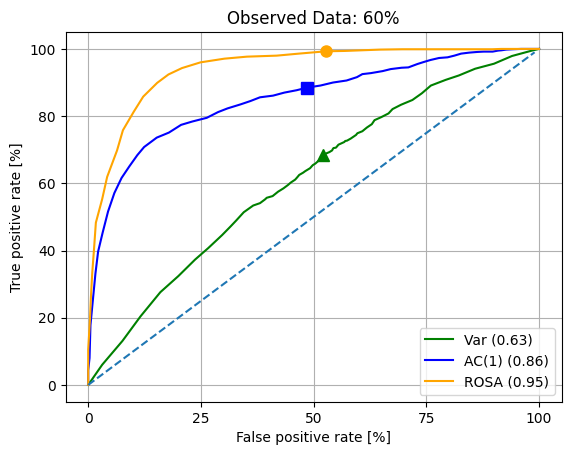

In [183]:
fig, ax = plt.subplots()

ax.plot(false_positives_06[:,0],true_positives_06[:,0], color = "green", label = f"Var ({auc_var_06})")
ax.plot(false_positives_06[:,0][500],true_positives_06[:,0][500],marker = '^',markersize = 8,color='green')
ax.plot(false_positives_06[:,1],true_positives_06[:,1], color = "blue", label = f"AC(1) ({auc_ac_06})")
ax.plot(false_positives_06[:,1][500],true_positives_06[:,1][500],marker = 's',markersize = 8,color='blue')
ax.plot(false_positives_06[:,2],true_positives_06[:,2], color = "orange", label = f"ROSA ({auc_ls_06})")
ax.plot(false_positives_06[:,2][500],true_positives_06[:,2][500],marker = 'o',markersize = 8,color='orange')
ax.plot(np.arange(100),np.arange(100),linestyle="--")

ax.set_xlabel('False positive rate [%]')
ax.set_xticks([0,25,50,75,100])

ax.set_ylabel('True positive rate [%]')
ax.set_title('Observed Data: 60%')

ax.grid(True)
ax.legend()